In [1]:
import os
import pathlib

import geopandas as gpd
import pandas as pd
import rioxarray as rxr
import xarray as xr

In [2]:
# Define and create the project data directories
data_dir = os.path.join(
    pathlib.Path.home(),
    'GitHub',
    'rivercane_data'
)

os.makedirs(data_dir, exist_ok=True)

In [3]:
# Retrieve location data
%store -r

In [4]:
# Get climate model info from The Climate Model Intercomparison Project
# Make coordinates compatible with shapefile for Oklahoma
def convert_longitude(longitude):
    """Convert longitude range from 0-360 to -180-180"""
    return (longitude -360) if longitude > 180 else longitude

ok_miroc5_da_list = []
for state_site, site_gdf in {'Oklahoma': cherokee_county}.items():
    for variable in ['pr']:
        for start_year in [2096]:
            end_year = start_year + 3
            miroc5_url = (
                'http://thredds.northwestknowledge.net:8080'
                '/thredds/dodsC/MACAV2/MIROC5/'
                f'macav2metdata_{variable}_MIROC5_r1i1p1_rcp45_'
                f'{start_year}_{end_year}_CONUS_monthly.nc')
            ok_miroc5_da = xr.open_dataset(miroc5_url).squeeze().precipitation
            bounds = cherokee_county.to_crs(ok_miroc5_da.rio.crs).total_bounds
            ok_miroc5_da = ok_miroc5_da.assign_coords(
                lon=("lon", 
                     [convert_longitude(l) for l in ok_miroc5_da.lon.values]))
            ok_miroc5_da = ok_miroc5_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
            ok_miroc5_da.rio.clip_box (*bounds) 
            ok_miroc5_da_list.append(dict(
                state_site=state_site,
                variable=variable,
                start_year=start_year,
                da=ok_miroc5_da))
            
oklahoma_df = pd.DataFrame(ok_miroc5_da_list)
oklahoma_df[['state_site', 'variable', 'start_year']]

,state_site,variable,start_year
0,Oklahoma,pr,2096


In [6]:
# Get climate model info from The Climate Model Intercomparison Project
# Make coordinates compatible with shapefile for North Carolina
# If time allowed, ideally this would be combined in a function that extracts
# both Oklahoma data and North Carolina data 
def convert_longitude(longitude):
    """Convert longitude range from 0-360 to -180-180"""
    return (longitude -360) if longitude > 180 else longitude

nc_miroc5_da_list = []
for state_site, site_gdf in {'North Carolina': jackson_county}.items():
    for variable in ['pr']:
        for start_year in [2096]:
            end_year = start_year + 3
            miroc5_url = (
                'http://thredds.northwestknowledge.net:8080'
                '/thredds/dodsC/MACAV2/MIROC5/'
                f'macav2metdata_{variable}_MIROC5_r1i1p1_rcp45_'
                f'{start_year}_{end_year}_CONUS_monthly.nc')
            nc_miroc5_da = xr.open_dataset(miroc5_url).squeeze().precipitation
            nc_bounds = jackson_county.to_crs(nc_miroc5_da.rio.crs).total_bounds
            nc_miroc5_da = nc_miroc5_da.assign_coords(
                lon=("lon", 
                     [convert_longitude(l) for l in nc_miroc5_da.lon.values]))
            nc_miroc5_da = nc_miroc5_da.rio.set_spatial_dims(x_dim='lon', y_dim='lat')
            nc_miroc5_da.rio.clip_box (*nc_bounds) 
            nc_miroc5_da_list.append(dict(
                state_site=state_site,
                variable=variable,
                start_year=start_year,
                da=nc_miroc5_da))
            
nc_df = pd.DataFrame(nc_miroc5_da_list)
nc_df[['state_site', 'variable', 'start_year']]

,state_site,variable,start_year
0,North Carolina,pr,2096


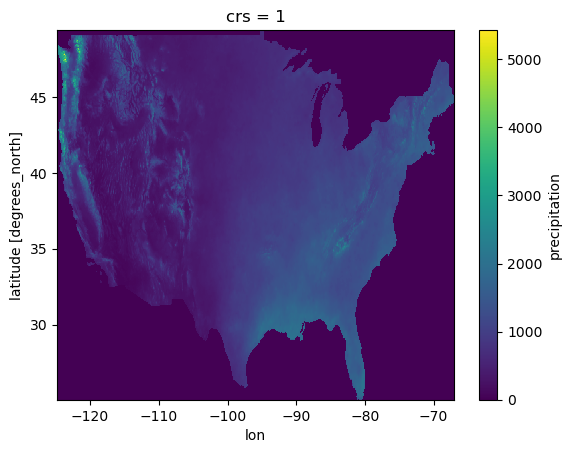

In [9]:
ok_miroc5_da = (
    oklahoma_df
    [(oklahoma_df.start_year==2096) & (oklahoma_df.variable=='pr')]
    .da.values.item()
    .groupby('time.year')
    .sum()
    .mean('year')
)
ok_miroc5_da.plot()